# 🧬 Battle Royale: Breeding Better Models
Welcome to the model evolution tournament! In this notebook, we evolve Logistic Regression models using different resampling strategies to detect rare events.

In [1]:
# 🛠️ Prioritize local 'src' directory for imports
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from preprocessing import load_and_prepare_data, split_and_scale, select_top_features
from resampling import (
    manual_upsampling, smote, adasyn, borderline_smote,
    smote_tomek, smote_enn, random_undersample, cluster_centroids
)
from model_eval import evaluate_model


In [3]:
# 📄 Load dataset
data_path = "../data/synth_rare_event_data.csv"
target_col = "rare_event"

X, y = load_and_prepare_data(data_path, target_col)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)
X_train, X_test, _ = select_top_features(X_train_scaled, y_train, X_test_scaled, return_features=True)

print(f"✅ Training: {X_train.shape}, Testing: {X_test.shape}")


✅ Training: (4000, 15), Testing: (1000, 15)


In [5]:
# 🧬 Define resampling strategies
resampled_datasets = {
    "Manual Upsampling": manual_upsampling(X_train, y_train),
    "SMOTE": smote(X_train, y_train),
    "ADASYN": adasyn(X_train, y_train),
    "Borderline SMOTE": borderline_smote(X_train, y_train),
    "SMOTETomek": smote_tomek(X_train, y_train),
    "SMOTEENN": smote_enn(X_train, y_train),
    "Random Undersample": random_undersample(X_train, y_train),
    "Cluster Centroids": cluster_centroids(X_train, y_train),
    "No Resampling": (X_train, y_train)
}


In [7]:
# 🧪 Define breeding function
def mutate_params(base_params, noise=0.1):
    return {
        "C": max(0.01, base_params["C"] + np.random.uniform(-noise, noise)),
        "l1_ratio": min(1.0, max(0.0, base_params["l1_ratio"] + np.random.uniform(-noise, noise)))
    }

def make_child_model(params):
    return LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=params["l1_ratio"],
        C=params["C"],
        max_iter=2000,
        tol=1e-4,
        class_weight='balanced',
        random_state=42
    )

def breed_and_battle(resampled_datasets, X_test, y_test, generations=3, top_k=3):
    population = []
    generation = 0
    base_params = {"C": 1.0, "l1_ratio": 0.5}

    for label, (X_res, y_res) in resampled_datasets.items():
        model = make_child_model(base_params)
        model.fit(X_res, y_res)
        score = evaluate_model(model, X_test, y_test, label=label, return_scores=True)

        population.append({
            "model": model,
            "params": base_params,
            "score": score,
            "label": label,
            "generation": generation
        })

    for generation in range(1, generations + 1):
        print(f"\n👾 Generation {generation}")
        population = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)[:top_k]

        new_population = []
        for parent in population:
            print(f"🏅 Breeding from {parent['label']} (PR AUC: {parent['score']['pr_auc']:.4f})")
            for _ in range(2):
                child_params = mutate_params(parent["params"])
                X_res, y_res = resampled_datasets[parent["label"]]
                model = make_child_model(child_params)
                model.fit(X_res, y_res)
                score = evaluate_model(model, X_test, y_test, label=f"{parent['label']} Gen{generation}", return_scores=True)
                new_population.append({
                    "model": model,
                    "params": child_params,
                    "score": score,
                    "label": parent["label"],
                    "generation": generation
                })

        population.extend(new_population)

    return population



--- Manual Upsampling ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


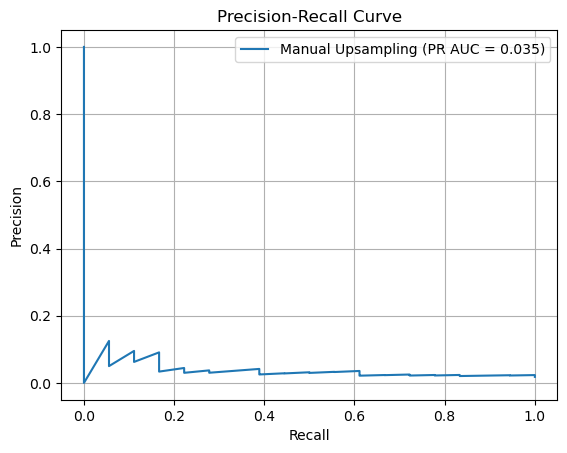

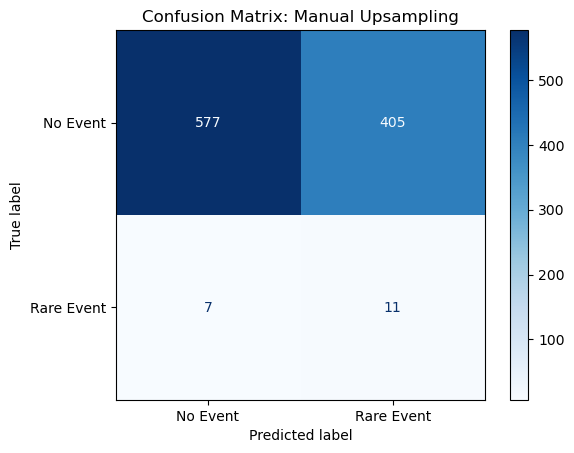


--- SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


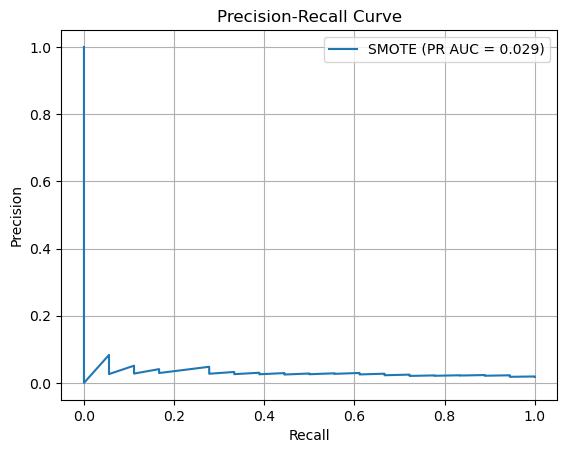

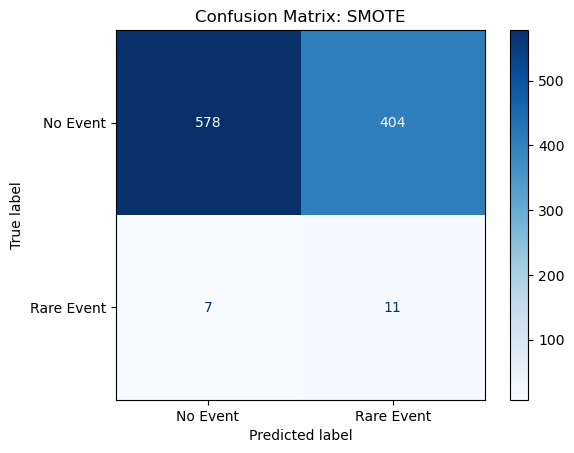


--- ADASYN ---
              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.02      0.50      0.04        18

    accuracy                           0.58      1000
   macro avg       0.50      0.54      0.39      1000
weighted avg       0.97      0.58      0.72      1000

ROC AUC: 0.617
PR AUC: 0.03


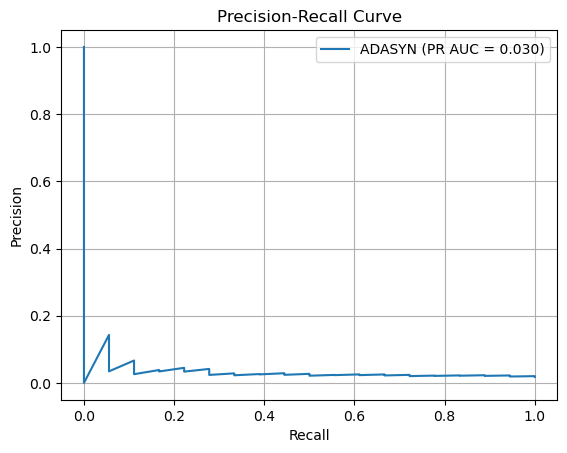

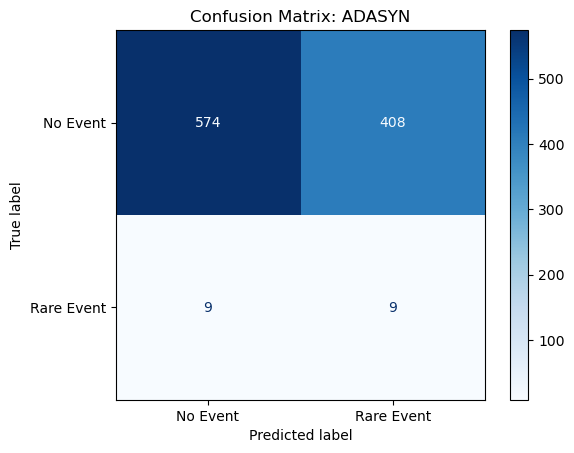


--- Borderline SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       982
           1       0.02      0.44      0.05        18

    accuracy                           0.67      1000
   macro avg       0.50      0.56      0.42      1000
weighted avg       0.97      0.67      0.79      1000

ROC AUC: 0.579
PR AUC: 0.026


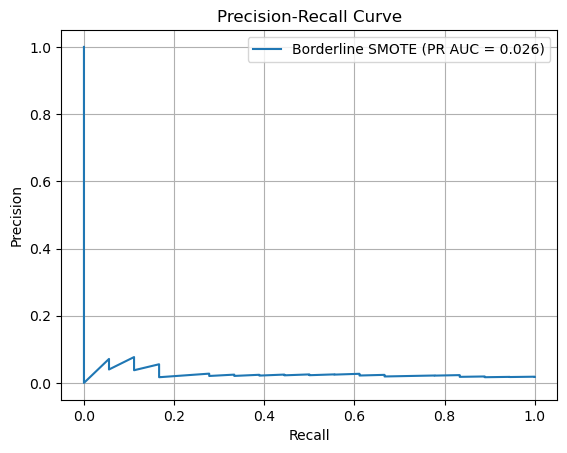

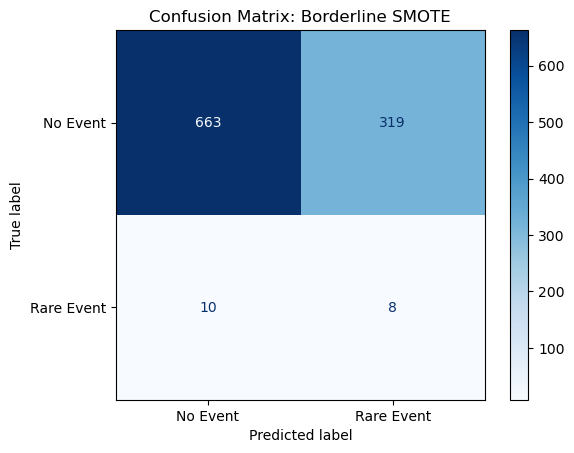


--- SMOTETomek ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.632
PR AUC: 0.029


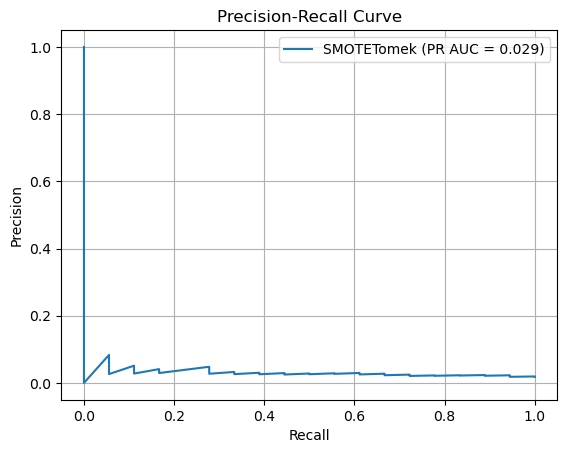

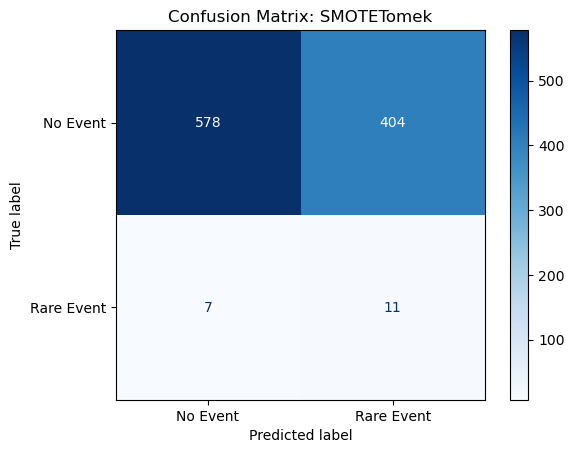


--- SMOTEENN ---
              precision    recall  f1-score   support

           0       0.99      0.57      0.73       982
           1       0.03      0.67      0.05        18

    accuracy                           0.57      1000
   macro avg       0.51      0.62      0.39      1000
weighted avg       0.97      0.57      0.71      1000

ROC AUC: 0.619
PR AUC: 0.027


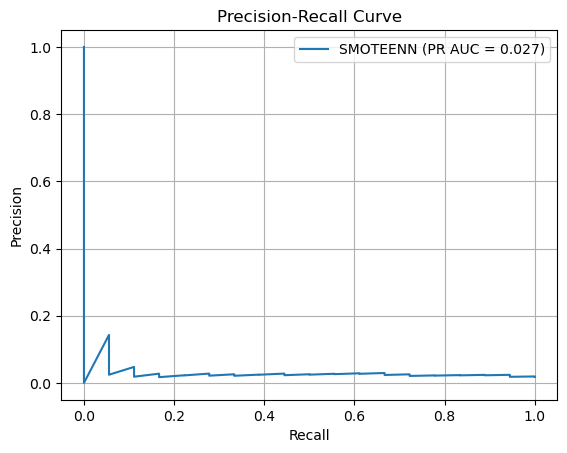

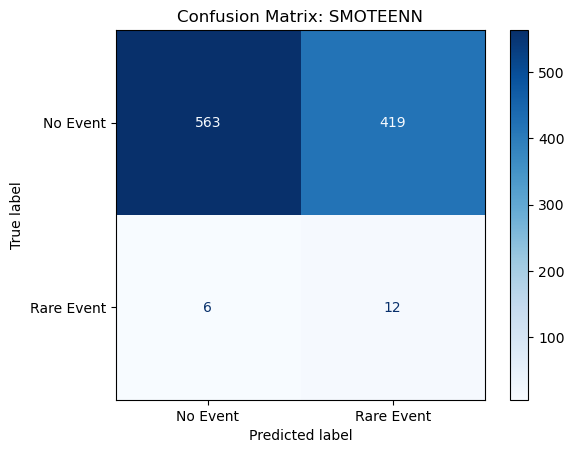


--- Random Undersample ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.54      1000
   macro avg       0.50      0.55      0.37      1000
weighted avg       0.97      0.54      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


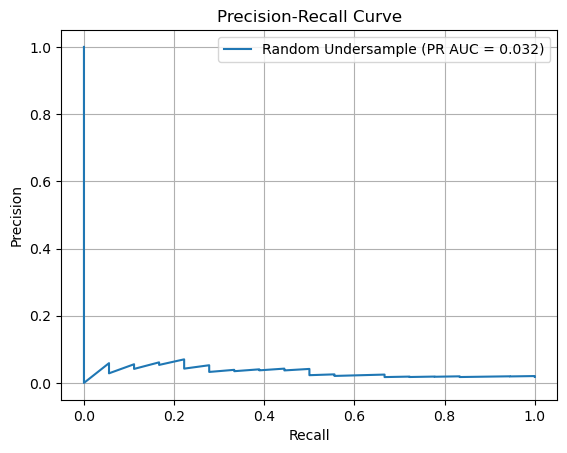

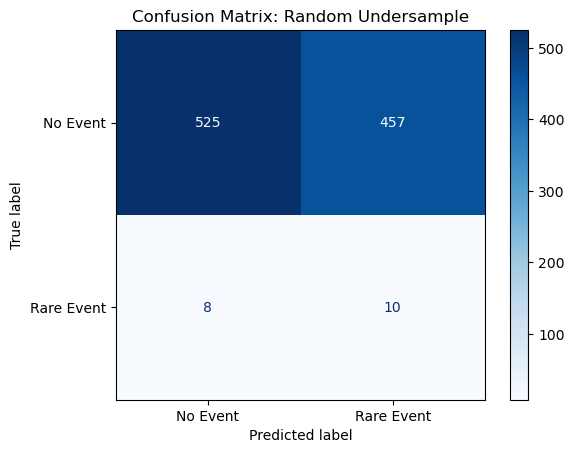


--- Cluster Centroids ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


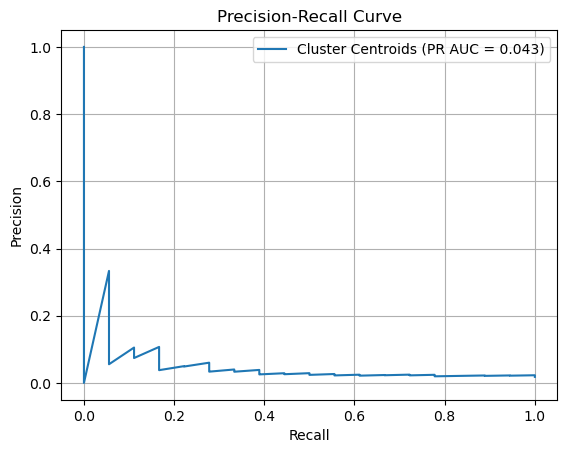

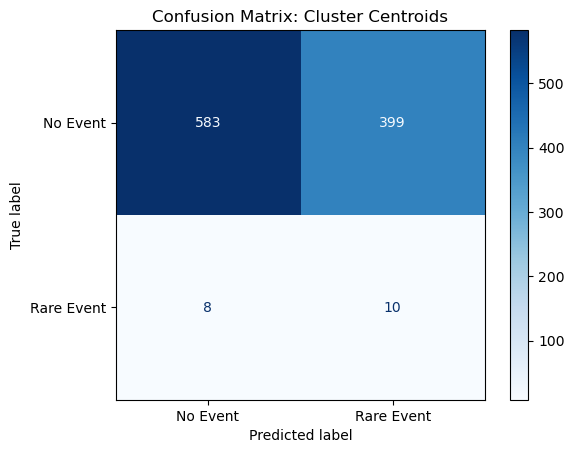


--- No Resampling ---
              precision    recall  f1-score   support

           0       0.98      0.47      0.63       982
           1       0.02      0.56      0.04        18

    accuracy                           0.47      1000
   macro avg       0.50      0.51      0.33      1000
weighted avg       0.97      0.47      0.62      1000

ROC AUC: 0.529
PR AUC: 0.023


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


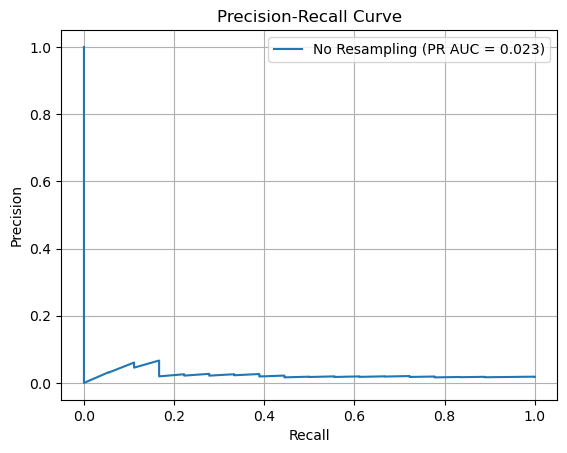

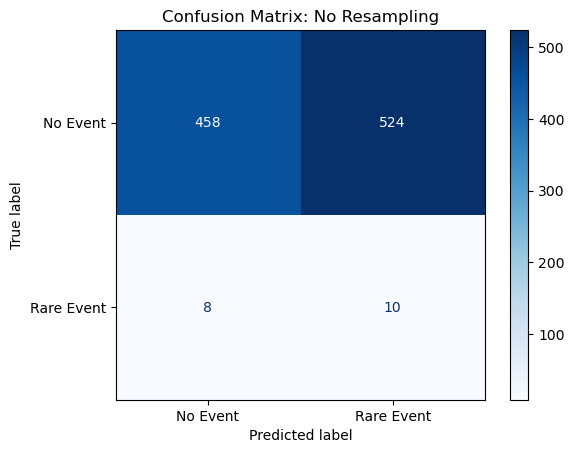


👾 Generation 1
🏅 Breeding from Cluster Centroids (PR AUC: 0.0426)

--- Cluster Centroids Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


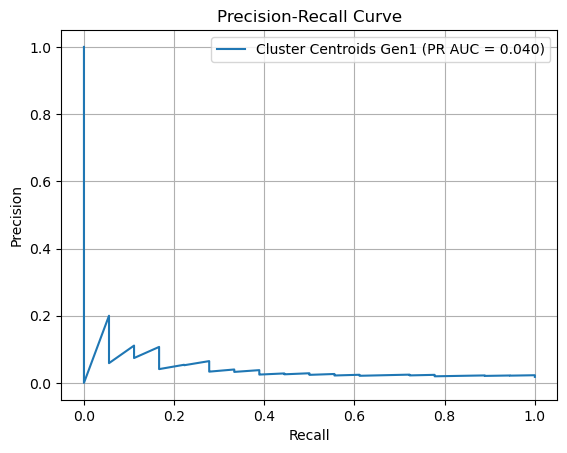

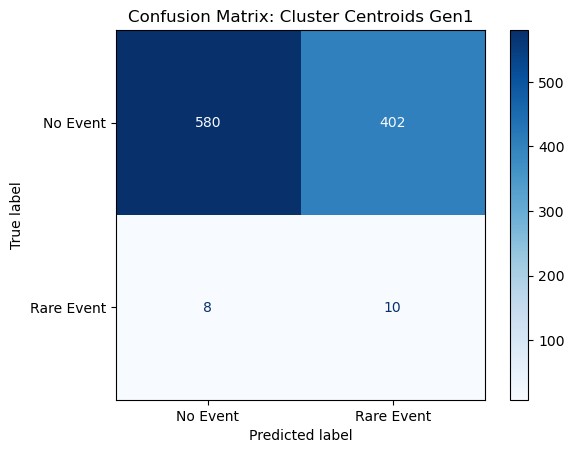


--- Cluster Centroids Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


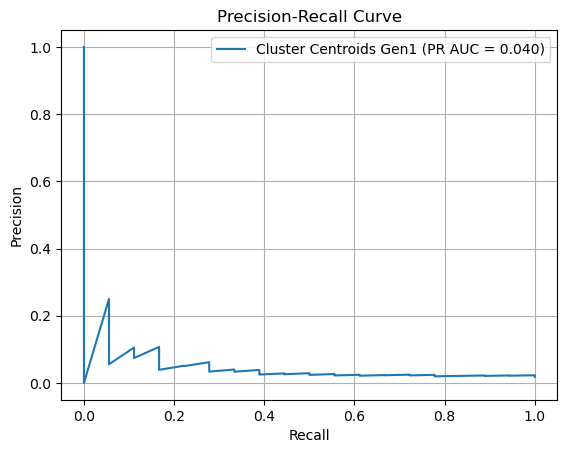

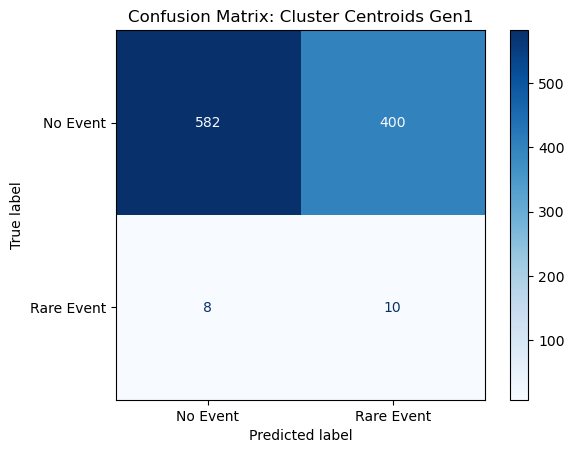

🏅 Breeding from Manual Upsampling (PR AUC: 0.0354)

--- Manual Upsampling Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


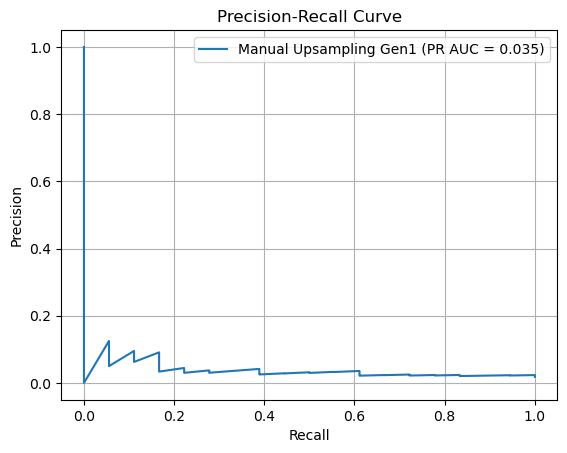

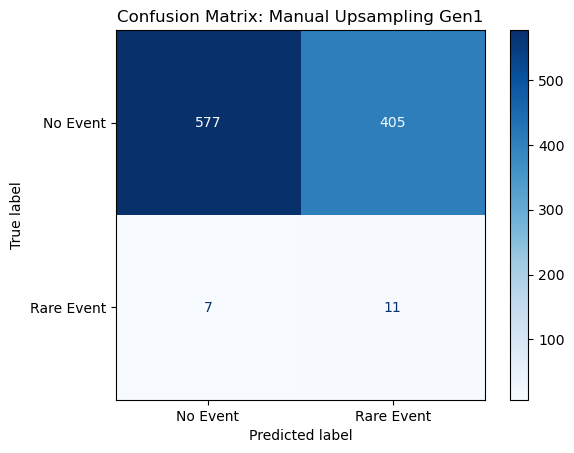


--- Manual Upsampling Gen1 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.03      0.61      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.60      0.39      1000
weighted avg       0.97      0.59      0.72      1000

ROC AUC: 0.653
PR AUC: 0.035


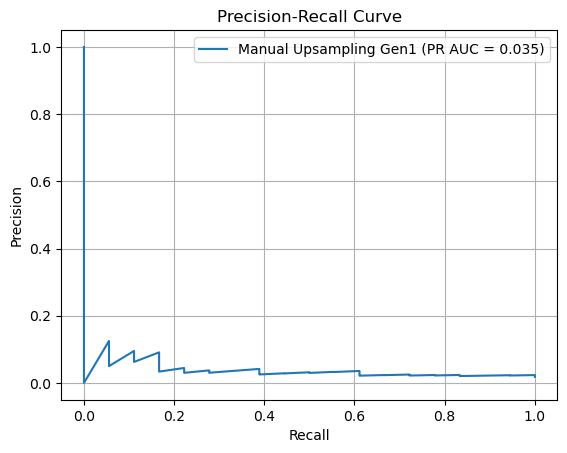

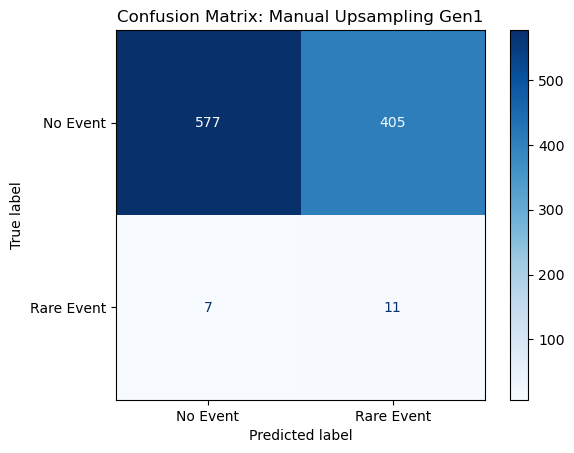

🏅 Breeding from Random Undersample (PR AUC: 0.0315)

--- Random Undersample Gen1 ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.53      1000
   macro avg       0.50      0.54      0.37      1000
weighted avg       0.97      0.53      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


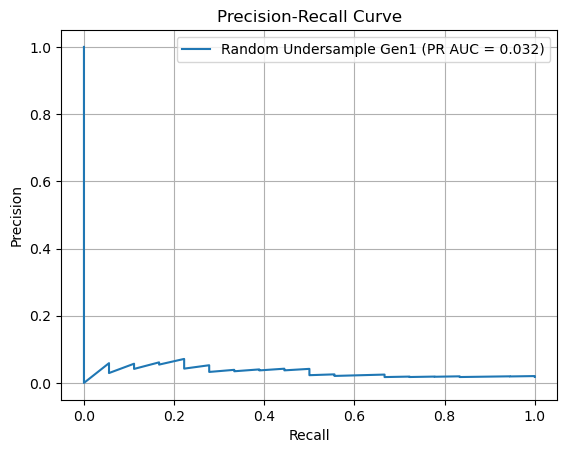

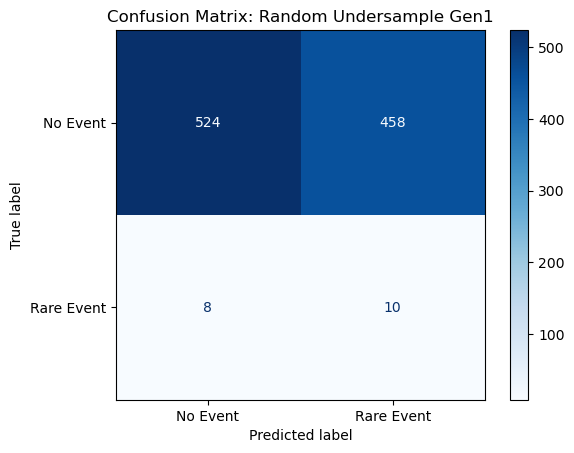


--- Random Undersample Gen1 ---
              precision    recall  f1-score   support

           0       0.98      0.53      0.69       982
           1       0.02      0.56      0.04        18

    accuracy                           0.54      1000
   macro avg       0.50      0.55      0.37      1000
weighted avg       0.97      0.54      0.68      1000

ROC AUC: 0.606
PR AUC: 0.032


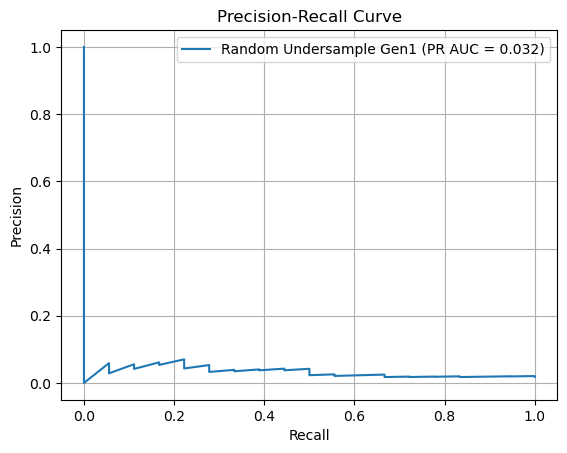

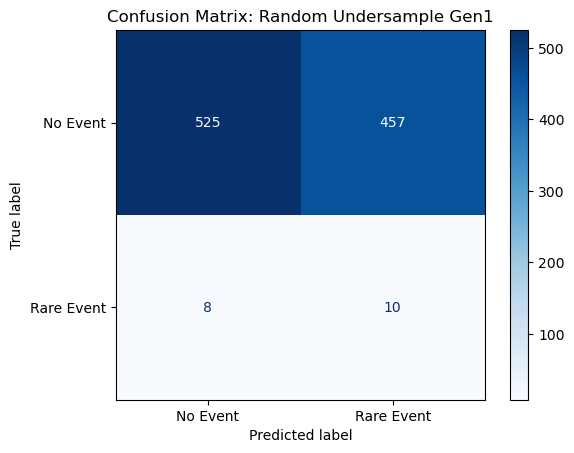


👾 Generation 2
🏅 Breeding from Cluster Centroids (PR AUC: 0.0426)

--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.64
PR AUC: 0.043


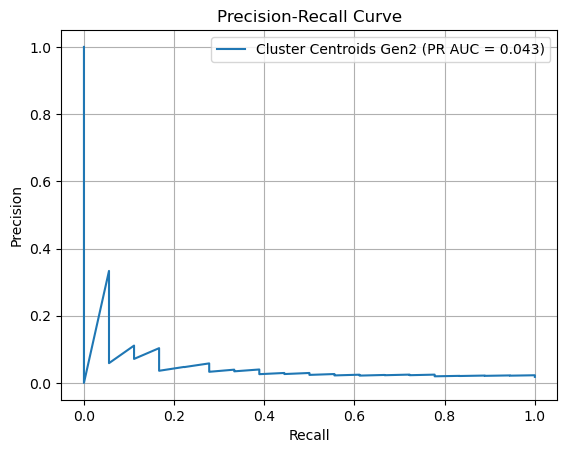

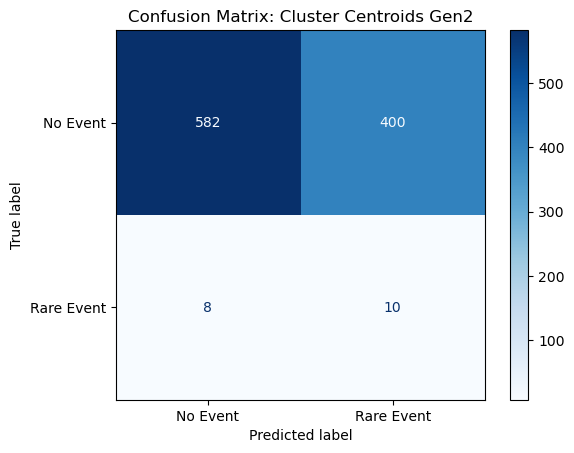


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.039


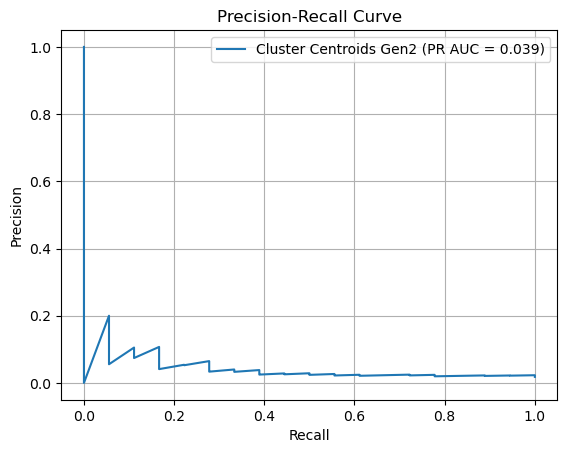

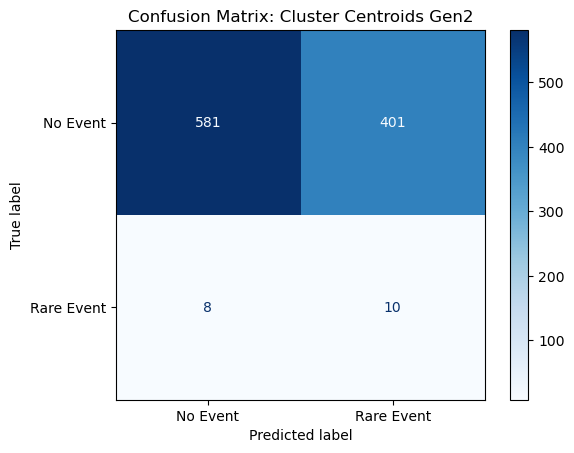

🏅 Breeding from Cluster Centroids (PR AUC: 0.0404)

--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


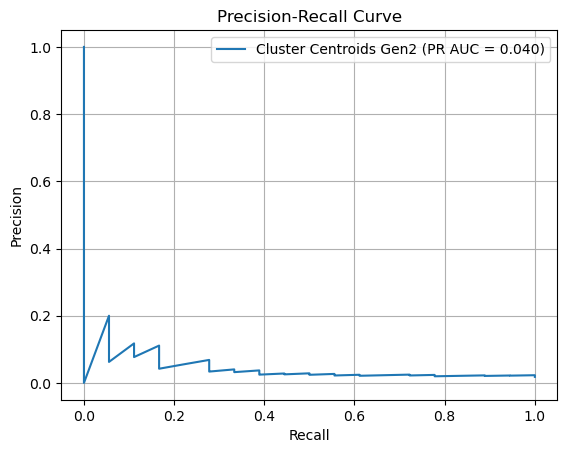

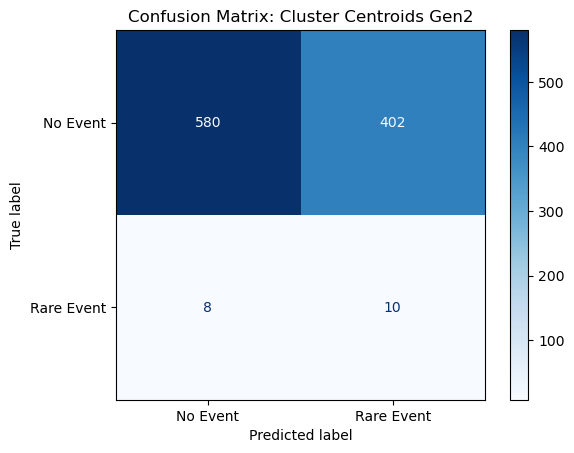


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


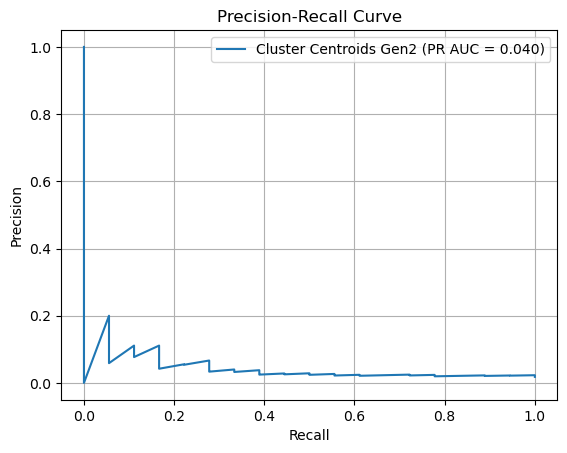

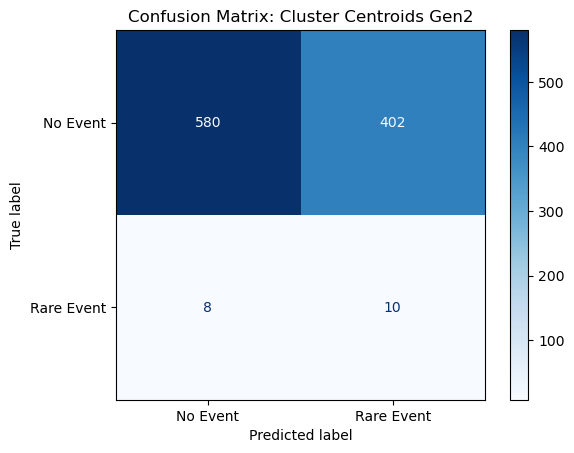

🏅 Breeding from Cluster Centroids (PR AUC: 0.0395)

--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.039


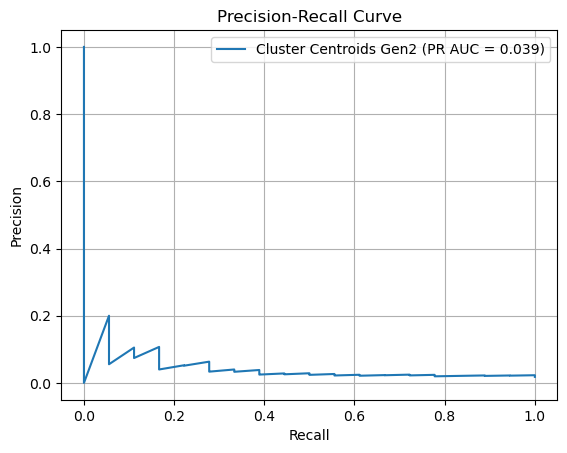

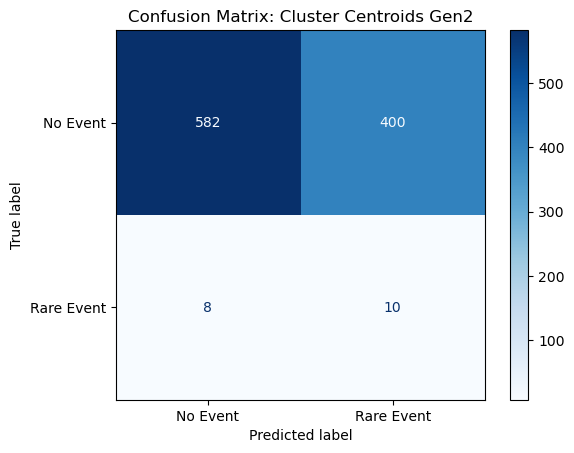


--- Cluster Centroids Gen2 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.638
PR AUC: 0.04


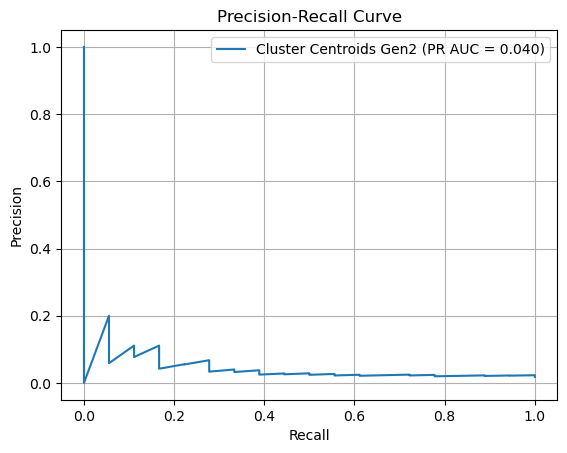

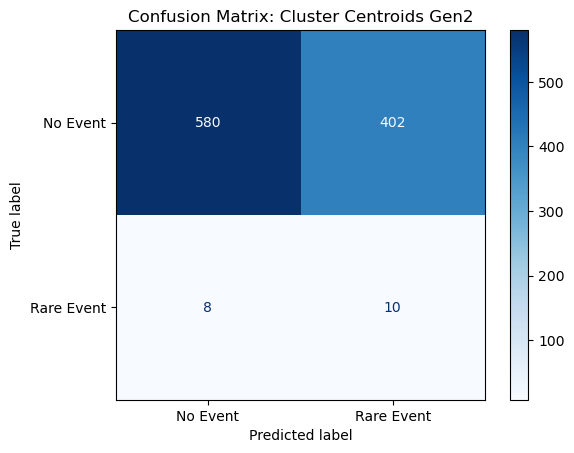


👾 Generation 3
🏅 Breeding from Cluster Centroids (PR AUC: 0.0426)

--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.042


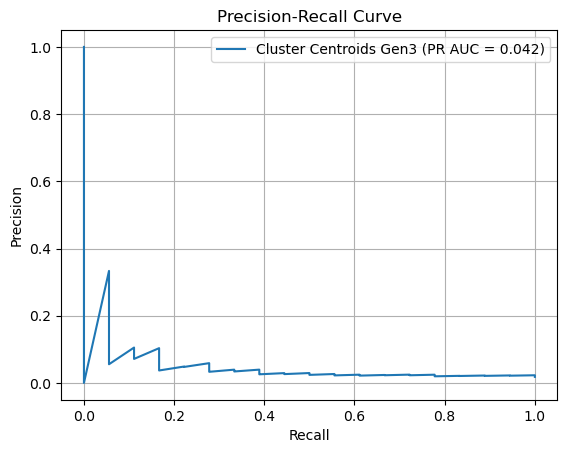

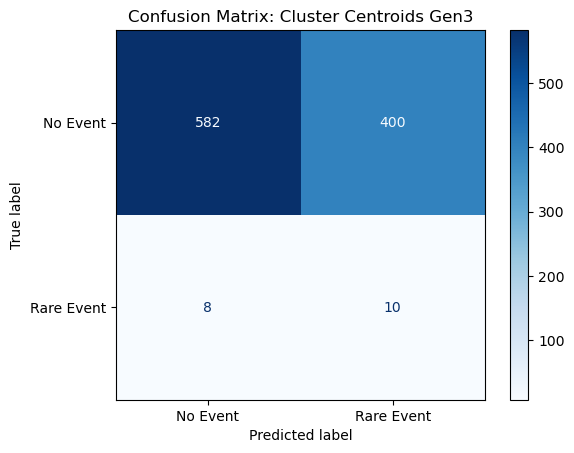


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.64
PR AUC: 0.042


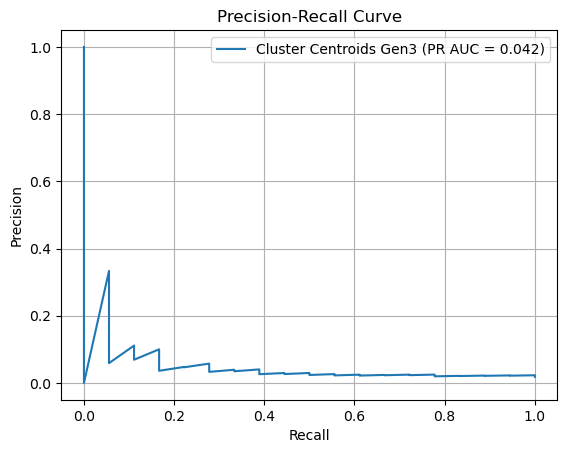

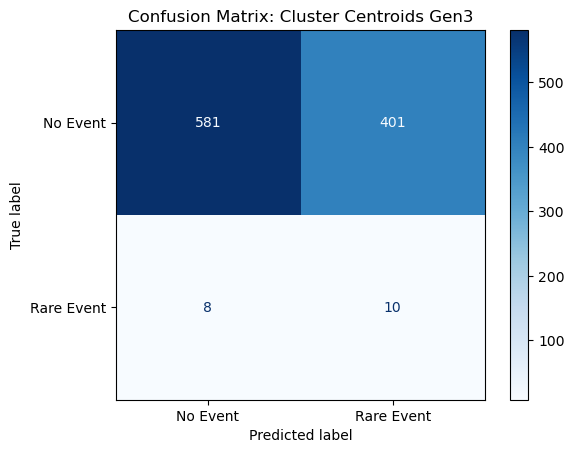

🏅 Breeding from Cluster Centroids (PR AUC: 0.0426)

--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.64
PR AUC: 0.042


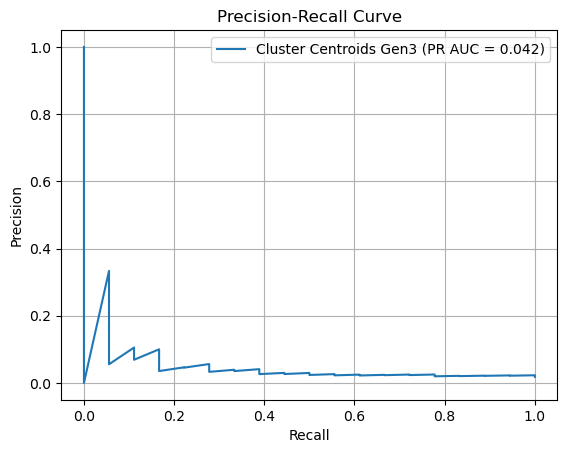

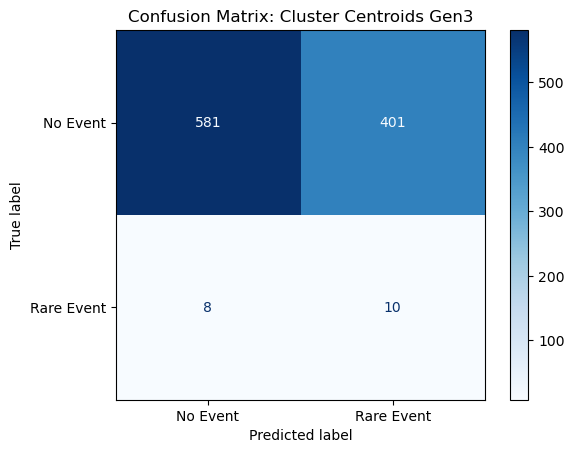


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


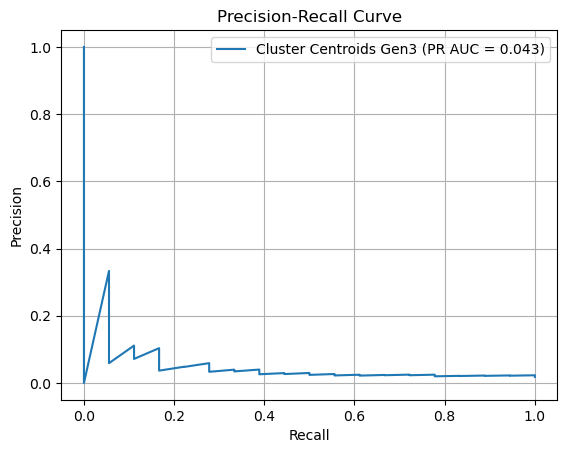

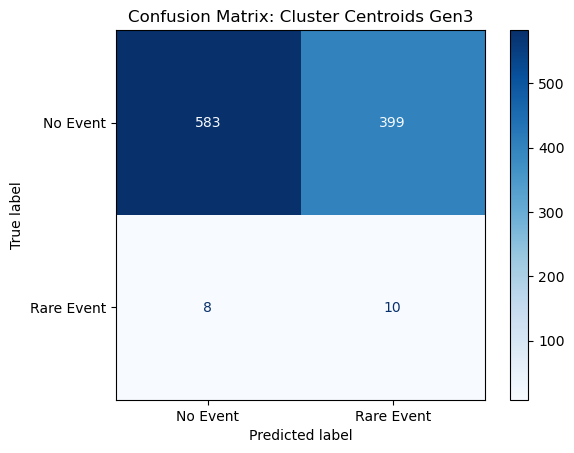

🏅 Breeding from Cluster Centroids (PR AUC: 0.0404)

--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.042


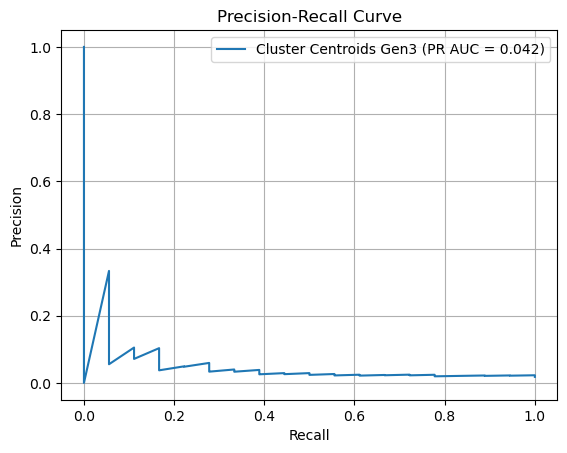

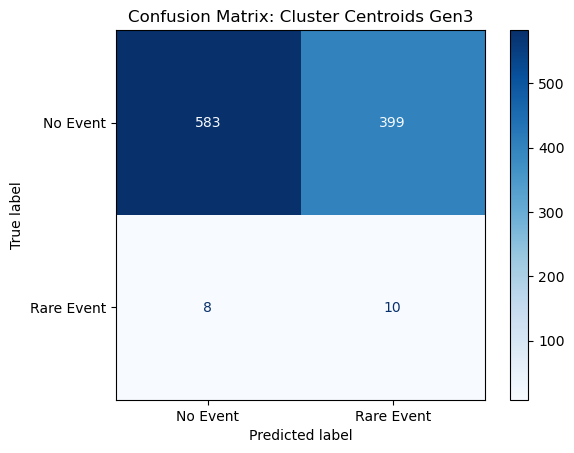


--- Cluster Centroids Gen3 ---
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       982
           1       0.02      0.56      0.05        18

    accuracy                           0.59      1000
   macro avg       0.51      0.57      0.39      1000
weighted avg       0.97      0.59      0.73      1000

ROC AUC: 0.639
PR AUC: 0.043


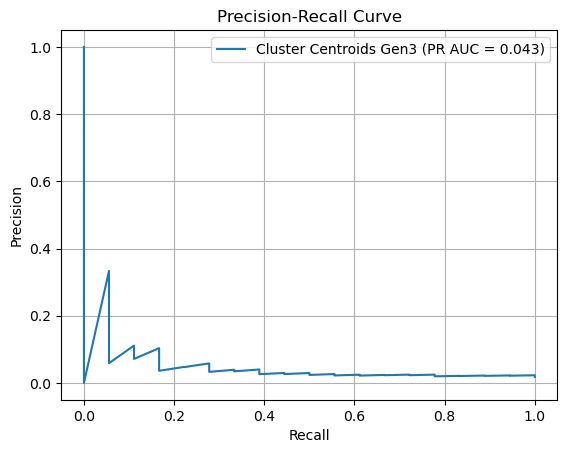

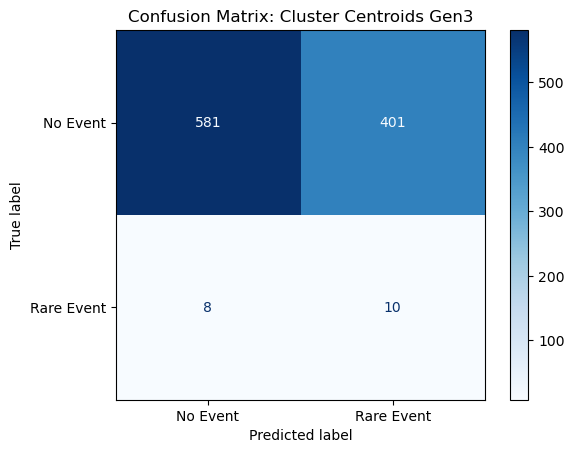

In [9]:
# 🚀 Run breed & battle
population = breed_and_battle(resampled_datasets, X_test, y_test, generations=3, top_k=3)


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


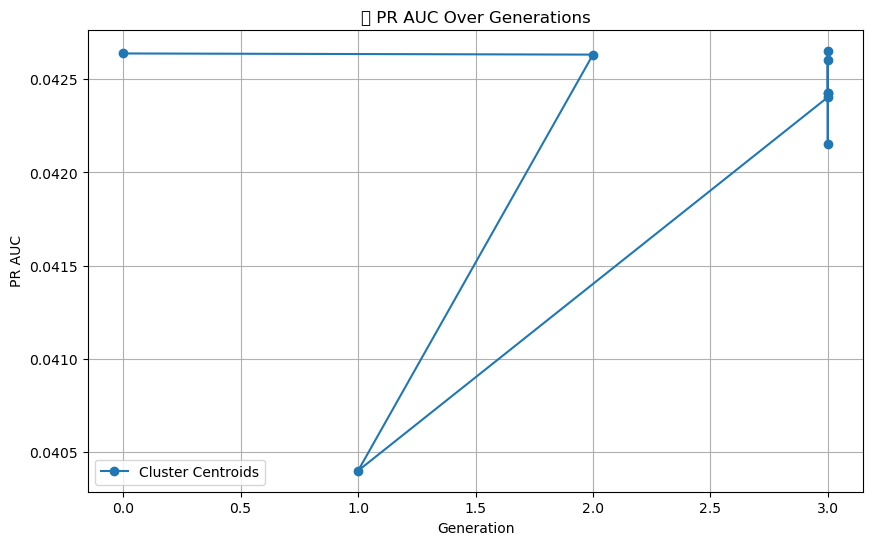

In [11]:
# 📊 Track performance
df = pd.DataFrame([
    {
        "Generation": m["generation"],
        "Strategy": m["label"],
        "PR AUC": m["score"]["pr_auc"],
        "ROC AUC": m["score"]["roc_auc"],
        "C": m["params"]["C"],
        "l1_ratio": m["params"]["l1_ratio"]
    } for m in population
])

plt.figure(figsize=(10, 6))
for label in df["Strategy"].unique():
    subset = df[df["Strategy"] == label]
    plt.plot(subset["Generation"], subset["PR AUC"], marker='o', label=label)

plt.title("📈 PR AUC Over Generations")
plt.xlabel("Generation")
plt.ylabel("PR AUC")
plt.grid(True)
plt.legend()
plt.show()


,Strategy,Generation,PR AUC,ROC AUC,C,l1_ratio
0,Cluster Centroids,3,0.042654,0.639285,1.055644,0.467044


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


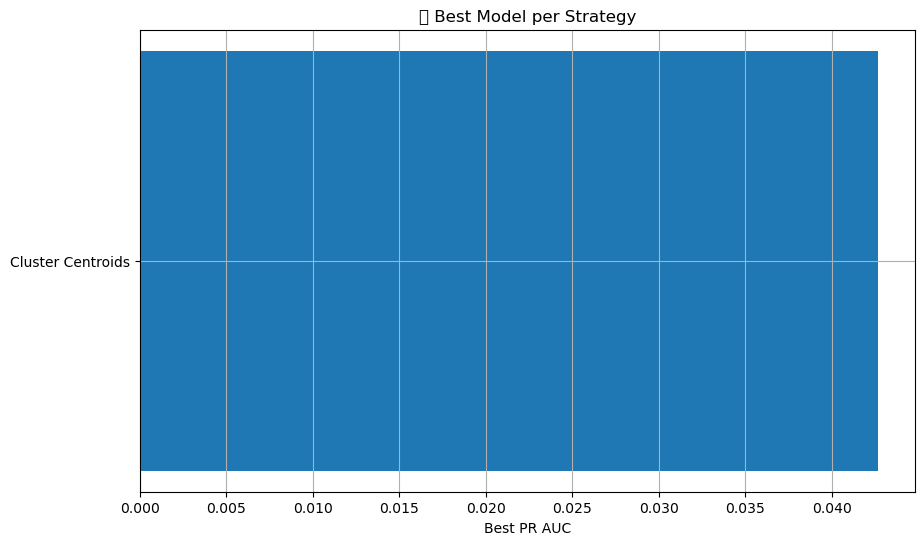

In [13]:
# 🏆 Best model per strategy
best_by_strategy = df.sort_values(by="PR AUC", ascending=False).groupby("Strategy").first().reset_index()

display(best_by_strategy[["Strategy", "Generation", "PR AUC", "ROC AUC", "C", "l1_ratio"]])

plt.figure(figsize=(10, 6))
plt.barh(best_by_strategy["Strategy"], best_by_strategy["PR AUC"])
plt.xlabel("Best PR AUC")
plt.title("🔍 Best Model per Strategy")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
